In [60]:
using Plots
using Random
using Distributions
using LinearAlgebra
include("pogm_restart.jl") # issues adding MIRT so will use julia file instead
rng = Random.seed!(0)
N = 500
D = 100
d = 10
W = vec(zeros(D,1))
σ1_features = 2
σ2_features = 35
goodpts_features = 50

X = zeros(D,N)
Y = zeros(D,N)
Π = vec(zeros(N,1))
U1 = svd(rand(D,N)).U[:,1:d]
for k = 1:N
    # older code projecting points U1*U1'*rand(Uniform(-100,100),D)
    #X[:,k] =  U1*rand(Uniform(-57,57),d) 
    X[:,k] =  U1*rand(Normal(0,33),d)
end

for j=1:D
        if (j<= goodpts_features)
            Y[j,:] = X[j,:] + rand(Normal(0,σ1_features),N)
            W[j] = σ1_features^2
        else
            Y[j,:] = X[j,:] + rand(Normal(0,σ2_features),N)
            W[j] = σ2_features^2
        end
end

In [61]:
XL = []
YL = []
for i = 1:10
    rng = Random.seed!(i)
    X0 = zeros(D,N)
    Y0 = zeros(D,N)
    for k = 1:N
    # older code projecting points U1*U1'*rand(Uniform(-100,100),D)
        #X0[:,k] =  U1*rand(Uniform(-57,57),d) 
        X0[:,k] =  U1*rand(Normal(0,33),d)
    end
    push!(XL,X0)
    for j=1:D
        if (j<= goodpts_features)
            Y0[j,:] = X0[j,:] + rand(Normal(0,σ1_features),N)
        else
            Y0[j,:] = X0[j,:] + rand(Normal(0,σ2_features),N)
        end
    end
    push!(YL,Y0)
end

In [62]:
using Arpack
function HeteroPCA(Σ,r,T)
    N = Σ - Diagonal(Σ)
    for t in 1:T
        U,λ,V = svds(N,nsv=r)[1]
        Nt = U[:,1:r]*Diagonal(λ[1:r])*V[:,1:r]'
        N = N - Diagonal(N) + Diagonal(Nt)
    end
    U,λ,_ = svds(N,nsv=r)[1]
    return U
end
U_heteropca = HeteroPCA(Y*Y', 10, 1000);
error_heteropca = norm(U_heteropca*U_heteropca' - U1*U1', 2)/norm(U1*U1', 2)

0.586682428455554

In [63]:
using HePPCAT
heppCAT_nogroups = []
for i = 1:N
    push!(heppCAT_nogroups, Y[:,i])
end
homoPCA = heppcat(heppCAT_nogroups,d,0)   # init is homoscedastic PPCA
error_homoppca = norm(homoPCA.U*homoPCA.U' - U1*U1', 2)/norm(U1*U1', 2)

0.9440576536506329

In [94]:
function FEATURE_HPCA_UNKNOWN(Y, λr, N, μ, ρ)
    U_svd = svd(Y).U[:,1:N]
    X = deepcopy(U_svd*U_svd'*Y)
    Z = deepcopy(Y-X)
    var = FEATURE_ALL_GROUPS(Y,X)
    W = Diagonal(var.^-1)
    Λ2 = sign.(Y)
    Λ = deepcopy(Λ2 ./ (max(opnorm(Λ2), (1/λr)*norm(Λ2, Inf))))
    normY = norm(Y,2)
    count = 0
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    while ((norm(Y-X-Z,2)/normY > 1e-6) || (count <100))
        X = pssvt(Y-Z+(1/μ)*Λ, λr/μ,N)
        Z = inv(W+μ*I)*μ*(Y-X+(1/μ)*Λ)
        var = FEATURE_ALL_GROUPS(Y,X)
        W = diagm(var.^-1)
        Λ = Λ + μ*(Y-X-Z)
        μ = ρ*μ
        count = count + 1
    end
    U = svd(X).U[:,1:10]   
    return U
end

function FEATURE_HPCA_KNOWN(Y, λr,Π, N, μ, ρ)
    U_svd = svd(Y).U[:,1:N]
    X = deepcopy(U_svd*U_svd'*Y)
    Z = deepcopy(Y-X)
    W = Diagonal(Π.^-1)
    Λ2 = sign.(Y)
    Λ = deepcopy(Λ2 ./ (max(opnorm(Λ2), (1/λr)*norm(Λ2, Inf))))
    normY = norm(Y,2)
    count = 0
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    while ((norm(Y-X-Z,2)/normY > 1e-6) || (count <100))
        X = pssvt(Y-Z+(1/μ)*Λ, λr/μ,N)
        Z = inv(W+μ*I)*μ*(Y-X+(1/μ)*Λ)
        Λ = Λ + μ*(Y-X-Z)
        μ = ρ*μ
        count = count + 1
    end
    U = svd(X).U[:,1:10]   
    return X
end



function FEATURE_NO_GROUPS(Y, L)
    d = size(Y)[1]
    Π = diag((1/d)*(Y-L)*(Y-L)')
    return Π
end

function FEATURE_ALL_GROUPS(Y, L)
    Π = vec(zeros(size(Y)[1],1))
    d = size(Y)[1]
    goodpts = 50
    N = 100
    Π[1:goodpts] .= (1/(d*goodpts))*norm(Y[1:goodpts,:]-L[1:goodpts,:],2)^2
    Π[(goodpts+1):end] .= (1/(d*(N-goodpts)))*norm(Y[(goodpts+1):end, :]-L[(goodpts+1):end, :],2)^2
    return Π
end

FEATURE_ALL_GROUPS (generic function with 1 method)

In [50]:
λr = vcat(0.0:0.2:2.0)
error_hpca_admm = zeros(size(λr))
error_hpca_nuclear = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = FEATURE_HPCA_UNKNOWN(Y, λr[i], 10, 0.01, 1.005)  
    error_hpca_admm[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
    U_HPCA = FEATURE_HPCA_UNKNOWN(Y, λr[i], 0, 0.01, 1.005)  
    error_hpca_nuclear[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11


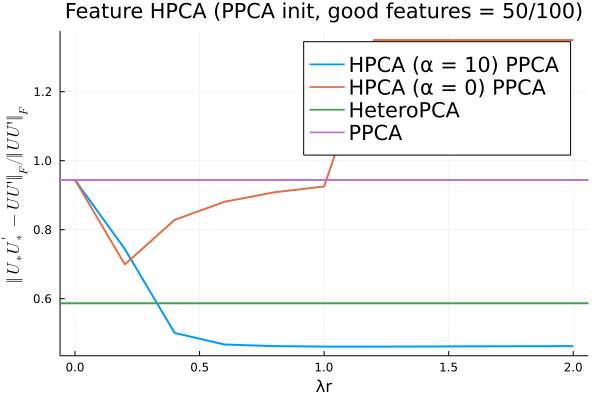

In [51]:
colors = theme_palette(:auto).colors;
using LaTeXStrings
plot(λr, error_hpca_admm, label="HPCA (α = 10) PPCA", title="Feature HPCA (PPCA init, good features = 50/100)", xlabel="λr", ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F",linewidth=2, legendfontsize=14.0)
plot!(λr, error_hpca_nuclear, label="HPCA (α = 0) PPCA", title="Feature HPCA (PPCA init, good features = 50/100)", xlabel="λr", ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F",linewidth=2, legendfontsize=14.0)
hline!([error_heteropca],label="HeteroPCA", linewidth=2, c=colors[3])
hline!([error_homoppca],label="PPCA", linewidth=2, c=colors[4])

In [218]:
# include("pogm_restart_original.jl")
# function HPCA_POGM(Y, λr, w, α, ϵ)
#     Π = w.^-1
#     Lf = maximum(Π)
#     Π = Diagonal(Π)
#     x0 = zeros(size(Y))
#     grad = K -> -1*(Y-K)*Π
#     soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
#     function pssvt(x,t,N)
#         U,S,V = svd(x)
#         S[(N+1):end] = soft.(S[(N+1):end],t)
#         return U*diagm(S)*V'
#     end
#     prox1 = (z,c) -> pssvt(z, c*λr, α)
#     W, _ = pogm_restart(x0, x -> 0, grad, Lf ; g_prox=prox1, niter=1000) # objective(x,Y-x,λr,w)
#     #U = svd(W).U[:,1:α]
#     return W
# end
# function AltMin(Y,λr,α,homoPCA_U)
#     X = homoPCA_U*homoPCA_U'*Y
#     X0 = deepcopy(X) .+ 1
#     Π = W_NO_GROUPS(Y,X)
#     #while (norm(X-X0)/norm(X) > 1e-6)
#     for i = 1:10
#         X0 = X
#         X = HPCA_POGM(Y,λr,Π,α,1e-1)
#         Π = W_NO_GROUPS(Y,X)
#     end
#     U = svd(X).U[:,1:α]
#     return U
# end

In [214]:
# λr = vcat(0.01:1:10)
# error_hpca_pogm = zeros(size(λr))
# for i=1:length(λr)
#     println(i)
#     flush(stdout)
#     U_HPCA = HPCA_POGM(Y, λr[i], Π, 10, 1e-6)  
#     error_hpca_pogm[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
# end

In [217]:
# λr = vcat(1:1:10)
# error_hpca_pogm = zeros(size(λr))
# for i=1:length(λr)
#     println(i)
#     flush(stdout)
#     U_HPCA = AltMin(Y, λr[i], 10, homoPCA.U)  
#     error_hpca_pogm[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
# end

In [21]:
heteropca_list = []
homopca_list = []
hpca_list = []
hpca_nuclear = []
λr = vcat(0.0:0.2:2.0)
error_hpca_admm = zeros(length(λr))
error_hpca_nuclear = zeros(length(λr))
for i=1:10
    println(i)
    flush(stdout)
    homoPCA_U = svd(YL[i]).U[:,1:10]
    errorPCA = norm(homoPCA_U*homoPCA_U' - U1*U1',2)/norm(U1*U1',2)
    push!(homopca_list, errorPCA)
    U_heteroPCA = HeteroPCA(YL[i]*YL[i]', 10, 1000);
    error_heteroPCA = norm(U_heteroPCA*U_heteroPCA' - U1*U1',2)/norm(U1*U1',2)
    push!(heteropca_list, error_heteroPCA)
    error_hpca_admm = zeros(size(λr))
    error_hpca_nuclear = zeros(size(λr))
    for j=1:length(λr)
        U_HPCA = FEATURE_HPCA_UNKNOWN(YL[i], λr[j], 10, 0.01, 1.005)  
        error_hpca_admm[j] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
        U_HPCA = FEATURE_HPCA_UNKNOWN(YL[i], λr[j], 0, 0.01, 1.005)  
        error_hpca_nuclear[j] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
    end
    push!(hpca_list, error_hpca_admm)
    push!(hpca_nuclear, error_hpca_nuclear)
end

1
2
3
4
5
6
7
8
9
10


In [22]:
homopca_mean = mean(homopca_list)
heteropca_mean = mean(heteropca_list);
hpca_mean = mean(hpca_list);
hpca_mean_nuclear = mean(hpca_nuclear);

In [11]:
colors = theme_palette(:auto).colors

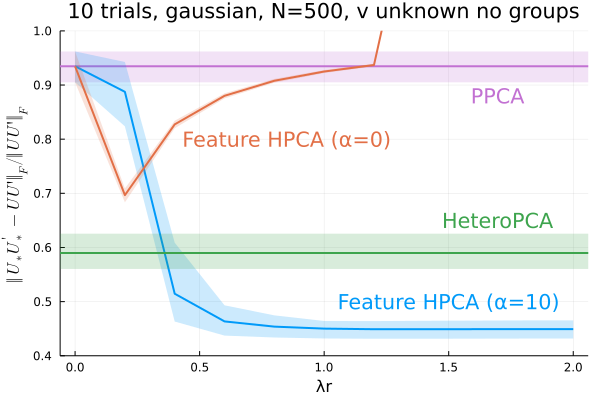

In [65]:
hline([homopca_mean],ribbon=(homopca_mean-minimum(homopca_list),maximum(homopca_list)-homopca_mean),c=colors[4], fillalpha = 0.2,linewidth=2, label="PPCA", legendfontsize=14, legend=false)
maxValue = vec(maximum(reduce(vcat,transpose.(hpca_list)),dims=1))
minValue = vec(minimum(reduce(vcat,transpose.(hpca_list)),dims=1))
maxValue_nuc = vec(maximum(reduce(vcat,transpose.(hpca_nuclear)),dims=1))
minValue_nuc = vec(minimum(reduce(vcat,transpose.(hpca_nuclear)),dims=1))
plot!(λr,hpca_mean, ribbon=(hpca_mean .- minValue, maxValue .- hpca_mean), fillalpha = 0.2, c=colors[1], linewidth=2, label="Feature HPCA (α=10)")
plot!(λr,hpca_mean_nuclear, ribbon=(hpca_mean_nuclear .- minValue_nuc, maxValue_nuc .- hpca_mean_nuclear), fillalpha = 0.2, c=colors[2], linewidth=2, label="Feature HPCA (α=0)")
hline!([heteropca_mean],ylims=(0.4,1.0),ribbon=(heteropca_mean-minimum(heteropca_list),maximum(heteropca_list)-heteropca_mean), c=colors[3], linewidth=2,fillalpha = 0.2, label="Hetero PCA")
plot!(xlabel="λr",ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F", title="10 trials, gaussian, N=500, v unknown no groups")
annotate!(1.7, 0.88, "PPCA", colors[4])
annotate!(1.5, 0.5, "Feature HPCA (α=10)", colors[1])
annotate!(1.7, 0.65, "HeteroPCA", colors[3])
annotate!(0.85, 0.8, "Feature HPCA (α=0)", colors[2])
#savefig("PAPER_FIGURE_FEATURE_HPCA_GAUSSIAN.pdf")

In [72]:
U_NNM = FEATURE_HPCA_KNOWN(Y, 0.5,W, 0, 0.01, 1.005);
norm(U_NNM*U_NNM' - U1*U1',2)/norm(U1*U1',2)

0.47178756628479274

In [75]:
hpca_list_nnm0 = []
hpca_nuclear_nnm10 = []
λr = vcat(0.0:0.2:2.0)
error_hpca_admm = zeros(length(λr))
error_hpca_nuclear = zeros(length(λr))
for i=1:10
    println(i)
    flush(stdout)
    error_hpca_admm = zeros(size(λr))
    error_hpca_nuclear = zeros(size(λr))
    for j=1:length(λr)
        U_HPCA = FEATURE_HPCA_KNOWN(YL[i], λr[j], W,0, 0.01, 1.005)  
        error_hpca_admm[j] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
        U_HPCA = FEATURE_HPCA_KNOWN(YL[i], λr[j],W, 10, 0.01, 1.005)  
        error_hpca_nuclear[j] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
    end
    push!(hpca_list_nnm0, error_hpca_admm)
    push!(hpca_nuclear_nnm10, error_hpca_nuclear)
end

1
2
3
4
5
6
7
8
9
10


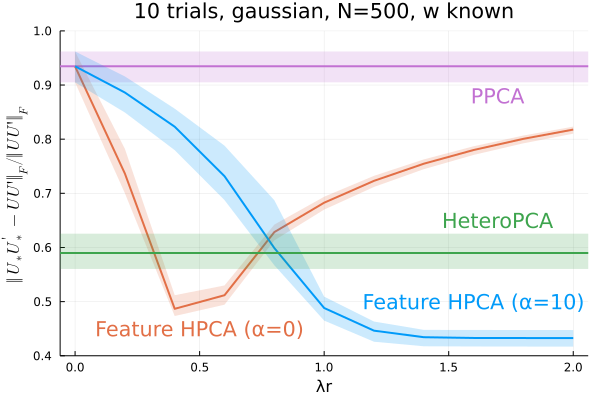

In [93]:
hpca_mean_nnm0 = mean(hpca_list_nnm0);
hpca_mean_nuclear_nnm10 = mean(hpca_nuclear_nnm10);

hline([homopca_mean],ribbon=(homopca_mean-minimum(homopca_list),maximum(homopca_list)-homopca_mean),c=colors[4], fillalpha = 0.2,linewidth=2, label="PPCA", legendfontsize=14, legend=false)
maxValue = vec(maximum(reduce(vcat,transpose.(hpca_list_nnm0)),dims=1))
minValue = vec(minimum(reduce(vcat,transpose.(hpca_list_nnm0)),dims=1))
maxValue_nuc = vec(maximum(reduce(vcat,transpose.(hpca_nuclear_nnm10)),dims=1))
minValue_nuc = vec(minimum(reduce(vcat,transpose.(hpca_nuclear_nnm10)),dims=1))
plot!(λr,hpca_mean_nnm0, ribbon=(hpca_mean_nnm0 .- minValue, maxValue .- hpca_mean_nnm0), fillalpha = 0.2, c=colors[2], linewidth=2, label="Feature HPCA (α=10)")
plot!(λr,hpca_mean_nuclear_nnm10, ribbon=(hpca_mean_nuclear_nnm10 .- minValue_nuc, maxValue_nuc .- hpca_mean_nuclear_nnm10), fillalpha = 0.2, c=colors[1], linewidth=2, label="Feature HPCA (α=0)")
hline!([heteropca_mean],ylims=(0.4,1.0),ribbon=(heteropca_mean-minimum(heteropca_list),maximum(heteropca_list)-heteropca_mean), c=colors[3], linewidth=2,fillalpha = 0.2, label="Hetero PCA")
plot!(xlabel="λr",ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F", title="10 trials, gaussian, N=500, w known")
annotate!(1.7, 0.88, "PPCA", colors[4])
annotate!(0.5, 0.45, "Feature HPCA (α=0)", colors[2])
annotate!(1.7, 0.65, "HeteroPCA", colors[3])
annotate!(1.6, 0.5, "Feature HPCA (α=10)", colors[1])
#savefig("PAPER_FIGURE_FEATURE_HPCA_GAUSSIAN_KNOWNCASE.pdf")

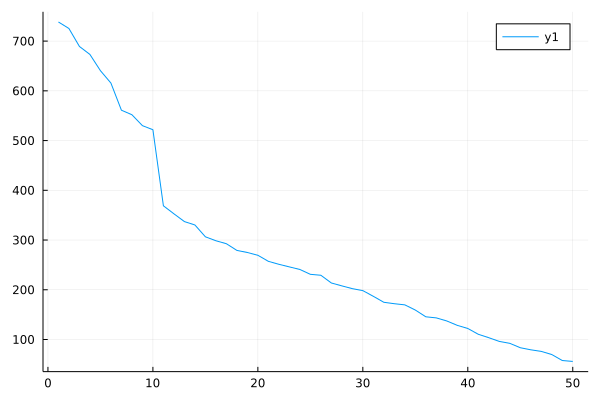

In [100]:
U_HPCA = FEATURE_HPCA_KNOWN(YL[5], 0.5, W,0, 0.01, 1.005) 
plot(svd(U_HPCA).S[1:50])